<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
import re
import datetime as dt
from collections import Counter

import pprint
import json 
%matplotlib inline

In [13]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.2


In [14]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

In [15]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# HELPER FUNCTIONS

In [16]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def from_json_str(cell, val):
    """
    I will use this helper function to retrieve the data from string representations
    of JSON responses available in some columns of my dataframes
    
    cell - cell where json value is stored
    val - value to search
    """
    json_acceptable_string = cell.replace("'", "\"")
    temp = json.loads(json_acceptable_string)
    
    return temp[val]

def double_countplot(df, field, w=25):
    """
    Draws 2 countplots one below the other. Useful to visualize test and train data
    simultaneously.
    
    df - dataframe
    field - field to visualize
    w - width of the countplot
    """
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(w,5))
    fig.subplots_adjust(hspace=1)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
    ax[0].set_title('Train')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
    ax[1].set_title('Test')
    sns.countplot(df[df['source']=='train'][field], ax=ax[0])
    sns.countplot(df[df['source']=='test'][field], ax=ax[1])
    
def translate_by_dict(word, dic):
    """
    Translation function
    """
    if word in dic.values():
        # nothing to translate - the word is already correct
        return word
    else:
        result = dic.get(word)
        if result:
            return result
        else:
            return 'other'    
        
def get_engine_displacement(x):
    """
    Processes a string description of engine to extract only its volume
    """  
    t = x.split(' ')[0]
    t = re.sub(r"[-,A-Z,a-z,-,_,' ']+", '', t, flags=re.IGNORECASE)
    if len(t) == 0:
        return -1
    elif (',' in t) or ('.' in t):
        return float(t)
    else:
        try:
            return int(t[:2])/10
        except ValueError:
            return -1        
        
def ownership_period(r):
    """
    This function converts text representation of ownership period into numeric value.
    It deals with 3 cases:
     - ownership period represented as dictionary: {'year': 2018, 'month': 12};
     - ownership period represented as string: 1 год и 10 месяцев;
     - missing value.
    """
    x = r['Владение']
    p = r['productionDate']
    try:
        if np.isnan(x):
            # this part will return numner of months since the beginning of production year up to now
            prod = dt.date(2020,1,1)
            return round((dt.date.today() - prod)/dt.timedelta(days=30))
    except TypeError:
        json_acceptable_string = x.replace("'", "\"")
        try:
            temp = json.loads(json_acceptable_string)
            to_dt = round((dt.date.today() - dt.date(temp['year'], temp['month'], 1))/dt.timedelta(days=30))
            return to_dt
        except ValueError:
            temp = x.split(' ')
            y, m = 0, 0
            for i, t in enumerate(temp):
                if i+1 <= len(temp) -1:
                    if 'год' in str(temp[i+1]) or 'лет' in str(temp[i+1]):
                        y = int(t)
                    if 'мес' in str(temp[i+1]): 
                        m = int(t)
            return y*12 + m   
        
def df_cell_json(cell):
    """
    I will use this helper function to convert dataframe cell content to dictionary if possible
    
    cell - cell where json value is stored
    """
    try:
        #print(cell)
        json_acceptable_string = cell.replace("'", "\"")
        json_acceptable_string = json_acceptable_string.replace("True", "\"True\"")
        temp = json.loads(json_acceptable_string)
        return temp
    except (AttributeError, ValueError):
        return dict()     
    
def mass_box(data, lst):
    """
    Draws multiple box plots
    """  
    for i in lst:
        print(f"Average price values : {data.groupby(i)['price'].mean()}")
        plt.ylim(np.min(data['price']), np.mean(data['price'])*3)
        sns.boxplot(data = data, y='price', x=i, showmeans=True)
        plt.title(i)
        plt.show() 

# Setup

In [17]:
VERSION    = 16
#DIR_TRAIN  = '../input/train-set-20210113/' # подключил к ноутбуку внешний датасет
#DIR_TEST   = '../input/sf-dst-car-price-prediction/'

DIR_TRAIN  = '' # for my local PC (files are in the same folder as notebook)
DIR_TEST   = ''
VAL_SIZE   = 0.20   # 20%

# Data

In [18]:
#!ls '../input'

In [19]:
train = pd.read_csv(DIR_TRAIN+'own_train_set_20210115.csv') # this is my training set (downloaded from auto.ru on 20210113)
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [20]:
train.head(5)

,Unnamed: 0,bodyType,brand,color_hex,complectation_dict,equipment_dict,fuelType,modelDate,model_info,model_name,...,description,mileage,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price
0,0,Кабриолет,FORD,007F00,{'id': '0'},{},бензин,1908.0,"{'code': 'MODEL_T', 'name': 'Model T', 'ru_nam...",Модель Т,...,1 октября 1908 Форд воплотил в жизнь свою мечт...,1000,задний,LEFT,used,1.0,ORIGINAL,True,NaN,3800000.0
1,1,Хэтчбек 3 дв.,FORD,0000CC,{'id': '0'},{},бензин,1927.0,"{'code': 'MODEL_A', 'name': 'Model A', 'ru_nam...",Модель А,...,Машина растаможена в лоб\nНалог низкий\nМотор ...,5000,задний,LEFT,used,1.0,ORIGINAL,True,"{'year': 2007, 'month': 5}",4300000.0
2,2,Хэтчбек 3 дв.,FORD,C49648,{'id': '0'},{},бензин,1927.0,"{'code': 'MODEL_A', 'name': 'Model A', 'ru_nam...",Модель А,...,Это Форд А 28 года. Только перебран двигатель....,2000,задний,LEFT,used,1.0,ORIGINAL,True,NaN,3350000.0
3,3,Седан,FORD,040001,{'id': '0'},{},бензин,1932.0,"{'code': 'V8', 'name': 'V8', 'ru_name': 'в8', ...",в8,...,Форд А 1930 год. Купил в музее в США. На отлич...,99655,задний,LEFT,used,1.0,ORIGINAL,True,"{'year': 2014, 'month': 10}",2700000.0
4,4,Седан,FORD,040001,{'id': '0'},{},бензин,1932.0,"{'code': 'V8', 'name': 'V8', 'ru_name': 'в8', ...",в8,...,"Форд 8 реплика на базе газ 69, полный привод,в...",15000,задний,LEFT,used,2.0,DUPLICATE,True,NaN,580000.0


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60488 entries, 0 to 60487
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            60488 non-null  int64  
 1   bodyType              60486 non-null  object 
 2   brand                 60488 non-null  object 
 3   color_hex             60488 non-null  object 
 4   complectation_dict    60488 non-null  object 
 5   equipment_dict        60488 non-null  object 
 6   fuelType              60488 non-null  object 
 7   modelDate             60486 non-null  float64
 8   model_info            60488 non-null  object 
 9   model_name            60488 non-null  object 
 10  name                  60486 non-null  object 
 11  numberOfDoors         60486 non-null  float64
 12  productionDate        60488 non-null  int64  
 13  vehicleConfiguration  60486 non-null  object 
 14  vehicleTransmission   60486 non-null  object 
 15  vendor             

In [22]:
# Let's drop unnamed column and rename color_hex to color. Let's also add a 'train' label (called 'source') 
# because I will merge test and train dataframes later
train['color'] = train['color_hex']
train.drop(labels=['color_hex', 'Unnamed: 0'], inplace=True, axis=1)
train['source'] = 'train'
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60488 entries, 0 to 60487
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              60486 non-null  object 
 1   brand                 60488 non-null  object 
 2   complectation_dict    60488 non-null  object 
 3   equipment_dict        60488 non-null  object 
 4   fuelType              60488 non-null  object 
 5   modelDate             60486 non-null  float64
 6   model_info            60488 non-null  object 
 7   model_name            60488 non-null  object 
 8   name                  60486 non-null  object 
 9   numberOfDoors         60486 non-null  float64
 10  productionDate        60488 non-null  int64  
 11  vehicleConfiguration  60486 non-null  object 
 12  vehicleTransmission   60486 non-null  object 
 13  vendor                60488 non-null  object 
 14  engineDisplacement    60486 non-null  object 
 15  enginePower        

In [23]:
# Now let's add an empty price column and source='test' to test dataset and merge both dataframes.
# I need that to compare contents and perform data pre-processing.
test['price'] = -1
test['source'] = 'test'

# Let's leave only the columns I have in a train dataset.
test = test[list(train.columns)]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   complectation_dict    6418 non-null   object
 3   equipment_dict        24690 non-null  object
 4   fuelType              34686 non-null  object
 5   modelDate             34686 non-null  int64 
 6   model_info            34686 non-null  object
 7   model_name            34686 non-null  object
 8   name                  34686 non-null  object
 9   numberOfDoors         34686 non-null  int64 
 10  productionDate        34686 non-null  int64 
 11  vehicleConfiguration  34686 non-null  object
 12  vehicleTransmission   34686 non-null  object
 13  vendor                34686 non-null  object
 14  engineDisplacement    34686 non-null  object
 15  enginePower           34686 non-null

In [24]:
test.head(5)

,bodyType,brand,complectation_dict,equipment_dict,fuelType,modelDate,model_info,model_name,name,numberOfDoors,...,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,color,source
0,лифтбек,SKODA,NaN,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,...,передний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,NaN,-1,синий,test
1,лифтбек,SKODA,NaN,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,...,передний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,-1,чёрный,test
2,лифтбек,SKODA,"{""id"":""20026336"",""name"":""Ambition"",""available_...","{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,...,передний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,-1,серый,test
3,лифтбек,SKODA,"{""id"":""20803582"",""name"":""Ambition"",""available_...","{""cruise-control"":true,""roller-blind-for-rear-...",бензин,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,...,передний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,-1,коричневый,test
4,лифтбек,SKODA,NaN,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,...,передний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,-1,белый,test


In [25]:
train.head()

,bodyType,brand,complectation_dict,equipment_dict,fuelType,modelDate,model_info,model_name,name,numberOfDoors,...,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,color,source
0,Кабриолет,FORD,{'id': '0'},{},бензин,1908.0,"{'code': 'MODEL_T', 'name': 'Model T', 'ru_nam...",Модель Т,2.9 MT (20 л.с.),2.0,...,задний,LEFT,used,1.0,ORIGINAL,True,NaN,3800000.0,007F00,train
1,Хэтчбек 3 дв.,FORD,{'id': '0'},{},бензин,1927.0,"{'code': 'MODEL_A', 'name': 'Model A', 'ru_nam...",Модель А,3.3 MT (40 л.с.),3.0,...,задний,LEFT,used,1.0,ORIGINAL,True,"{'year': 2007, 'month': 5}",4300000.0,0000CC,train
2,Хэтчбек 3 дв.,FORD,{'id': '0'},{},бензин,1927.0,"{'code': 'MODEL_A', 'name': 'Model A', 'ru_nam...",Модель А,3.3 MT (40 л.с.),3.0,...,задний,LEFT,used,1.0,ORIGINAL,True,NaN,3350000.0,C49648,train
3,Седан,FORD,{'id': '0'},{},бензин,1932.0,"{'code': 'V8', 'name': 'V8', 'ru_name': 'в8', ...",в8,3.6 MT (66 л.с.),2.0,...,задний,LEFT,used,1.0,ORIGINAL,True,"{'year': 2014, 'month': 10}",2700000.0,040001,train
4,Седан,FORD,{'id': '0'},{},бензин,1932.0,"{'code': 'V8', 'name': 'V8', 'ru_name': 'в8', ...",в8,3.6 MT (66 л.с.),2.0,...,задний,LEFT,used,2.0,DUPLICATE,True,NaN,580000.0,040001,train


# Exploring data

In [26]:
# I want to see a row from test and train dataframes side by side to compare them. 
# I have a suspicion that different languages might be used in these datasets.
for c in train.columns:
    print(f'Column {c} from train: {train.iloc[0][c]}')
    print(f'Column {c} from test: {test.iloc[0][c]}')
    print('')

Column bodyType from train: Кабриолет
Column bodyType from test: лифтбек

Column brand from train: FORD
Column brand from test: SKODA

Column complectation_dict from train: {'id': '0'}
Column complectation_dict from test: nan

Column equipment_dict from train: {}
Column equipment_dict from test: {"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-con

In [27]:
# I definitely see some attributes written in different languages. Let's check if the language is unique 
# within each dataset
for c in ['bodyType', 'brand', 'fuelType', 'modelDate', 'model_name', 'name', 'numberOfDoors', 'productionDate', 'vehicleTransmission', 
          'vendor', 'engineDisplacement', 'mileage', 'Привод', 'Руль', 'Состояние', 'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'color', 'enginePower']:
    print(f'Unique values for column {c} from train: {train[c].unique()}')
    print(f'Unique values for column {c} from test: {test[c].unique()}')
    print('')

Unique values for column bodyType from train: ['Кабриолет' 'Хэтчбек 3 дв.' 'Седан' 'Седан 2 дв.' 'Фастбек' 'Купе'
 'Седан 2 дв. Styleline' 'Пикап Одинарная кабина' 'Универсал 3 дв. 1201'
 'Минивэн' 'Купе-хардтоп' 'Хэтчбек 5 дв.' 'Внедорожник 3 дв.'
 'Универсал 5 дв.' 'Внедорожник открытый' 'Внедорожник 5 дв.' 'Фургон'
 'Лифтбек' 'Седан 120' 'Седан T140' 'Компактвэн' 'Пикап Полуторная кабина'
 nan 'Пикап Двойная кабина' 'Родстер' 'Седан-хардтоп' 'Тарга'
 'Родстер del Sol' 'Лифтбек Liftback' 'Седан-хардтоп Ceres'
 'Пикап Двойная кабина Double cab' 'Хэтчбек 3 дв. Compact' 'Минивэн Emina'
 'Минивэн Long' 'Седан Long' 'Минивэн Lucida' 'Компактвэн Joy'
 'Седан Premio' 'Купе Asti' 'Хэтчбек 5 дв. Wide' 'Компактвэн Noah'
 'Универсал 5 дв. Gracia' 'Микровэн' 'Универсал 5 дв. Qualis'
 'Универсал 5 дв. Ardeo' 'Универсал 5 дв. XC' 'Кабриолет Roadster'
 'Универсал 5 дв. S-Familia' 'Минивэн Caravan Elgrand'
 'Универсал 5 дв. California' 'Минивэн Grand' 'Внедорожник 5 дв. XL-7'
 'Компактвэн RX4' 'Унив

 "{'year': 2005, 'month': 7}" "{'year': 2006, 'month': 1}"]
Unique values for column Владение from test: [nan '3 года и 2 месяца' '11 месяцев' '4 года и 1 месяц'
 '2 года и 4 месяца' '1 месяц' '3 года и 10 месяцев' '2 года и 6 месяцев'
 '6 лет и 4 месяца' '2 месяца' '4 месяца' '1 год и 10 месяцев'
 '2 года и 7 месяцев' '7 лет и 11 месяцев' '7 лет и 5 месяцев'
 '1 год и 11 месяцев' '2 года и 1 месяц' '7 лет' '4 года и 2 месяца'
 '2 года и 8 месяцев' '2 года и 5 месяцев' '12 лет и 11 месяцев'
 '5 лет и 11 месяцев' '2 года и 11 месяцев' '3 года и 1 месяц'
 '1 год и 1 месяц' '1 год' '1 год и 7 месяцев' '3 месяца'
 '1 год и 5 месяцев' '1 год и 2 месяца' '7 лет и 8 месяцев'
 '3 года и 4 месяца' '1 год и 6 месяцев' '12 лет и 8 месяцев'
 '6 лет и 1 месяц' '6 лет и 11 месяцев' '5 лет и 4 месяца'
 '3 года и 5 месяцев' '6 лет и 2 месяца' '4 года и 6 месяцев'
 '3 года и 6 месяцев' '1 год и 8 месяцев' '1 год и 9 месяцев'
 '3 года и 11 месяцев' '2 года и 2 месяца' '3 года' '5 лет и 5 месяцев'
 '2 го

# Comments after running a previous cell (strikestrough means that I have done that):

~~1) BodyType should be casted to lowercase and only the first word should be used.~~

~~2) Train set contains 'универсал' and 'минивэн' as fuelTypes. This is clearly wrong. Need to check if I can fix this, or these records can simply be removed.~~

~~3) modelDate is float in a train set. Don't think it's a big issue, but still needs to be casted to int for convenience~~

~~4) model_name from train set should be converted to UPPERCASE English name somehow. Maybe I have this data in some dictionaries that were extracted from auto.ru - **YES I do ( model_info : {'code': 'CAMARO', 'name': 'Camaro', 'ru_name': 'Камаро', 'morphology': {}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}})**~~

~~5) name is a weird column. I think all of this data should be available in other columns. Will check that and just remove it if that's really the case.~~

~~6) numberOfDoors needs to be converted to int in train. There are also some missing values there.~~

~~7) vehicleTransmission has to be transformed to lowercase russian somehow. Missing values should also be treated properly.~~

~~8) Engine displacement is weird in train. Need to look for other source of this data.~~

~~9) Руль values should be translated to Russian in train. Both train and test should be cast to lowercase.~~

~~10) Состояние either have to be ignored or should be somehow aligned between train and test. Right now there's only 1 unique value for this feature, but it doesn't mean I should ignore it right away.~~

~~11) Владельцы should be cleaned in test (they should be numeric instead of text).~~

~~12) Таможня doesn't look like a meaningful feature because only 1 unique value exists both in test and train. Will remove it.~~

~~13) Владение should be converted to numeric.~~

~~14) Need to find a way to get Russian lowercase color names for train set.~~

~~15) enginePower in test has N12 (stands for metric horsepower). It needs to be removed and the whole column needs to be casted to numeric.~~

In [28]:
# Let's merge train and test datasets and apply modifications where necessary. 
df_merged = pd.concat([train, test])
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95174 entries, 0 to 34685
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              95172 non-null  object 
 1   brand                 95174 non-null  object 
 2   complectation_dict    66906 non-null  object 
 3   equipment_dict        85178 non-null  object 
 4   fuelType              95174 non-null  object 
 5   modelDate             95172 non-null  float64
 6   model_info            95174 non-null  object 
 7   model_name            95174 non-null  object 
 8   name                  95172 non-null  object 
 9   numberOfDoors         95172 non-null  float64
 10  productionDate        95174 non-null  int64  
 11  vehicleConfiguration  95172 non-null  object 
 12  vehicleTransmission   95172 non-null  object 
 13  vendor                95174 non-null  object 
 14  engineDisplacement    95172 non-null  object 
 15  enginePower        

## bodyType

In [29]:
# Looking at bodyType I see that it has a massive number of unique types. However, the details that come in a bodyType string after
# the first word are really not required. I will leave only the first word and cast to lowercase.
df_merged['bodyType'] = df_merged['bodyType'].str.split(' ').str[0].str.lower()
df_merged.groupby(['source', 'bodyType']).size()

source  bodyType     
test    внедорожник      12346
        кабриолет           90
        компактвэн         489
        купе               824
        купе-хардтоп       158
        лимузин              6
        лифтбек           2232
        микровэн             7
        минивэн            995
        пикап              290
        родстер             99
        седан            13153
        седан-хардтоп       12
        тарга                2
        универсал         1276
        фастбек              1
        фургон              97
        хэтчбек           2609
train   внедорожник      24223
        кабриолет          111
        компактвэн        1436
        купе               739
        купе-хардтоп         2
        лифтбек           3412
        микровэн            25
        минивэн           1650
        пикап              286
        родстер             42
        седан            18165
        седан-хардтоп       12
        тарга                5
        универсал

## fuelType

In [30]:
# Let's check weird fuel types in train
df_merged.groupby(['source', 'fuelType']).size()

source  fuelType 
test    бензин       28601
        газ              7
        гибрид         223
        дизель        5800
        электро         55
train   бензин       52142
        газ             12
        гибрид         196
        дизель        8041
        минивэн          1
        универсал        1
        электро         95
dtype: int64

In [31]:
# 'универсал','минивэн' are definitely not fuel types. Looks like we can drop them (only 2 values in total)
df_merged = df_merged[~df_merged['fuelType'].isin(['универсал','минивэн'])]
df_merged.groupby(['source', 'fuelType']).size()

source  fuelType
test    бензин      28601
        газ             7
        гибрид        223
        дизель       5800
        электро        55
train   бензин      52142
        газ            12
        гибрид        196
        дизель       8041
        электро        95
dtype: int64

## modelDate

In [32]:
# Let's look at modelDate. Are there any missing values
df_merged[df_merged['modelDate'].isna()]

,bodyType,brand,complectation_dict,equipment_dict,fuelType,modelDate,model_info,model_name,name,numberOfDoors,...,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,color,source


<ipython-input-16-68cb8a68848a>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
<ipython-input-16-68cb8a68848a>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

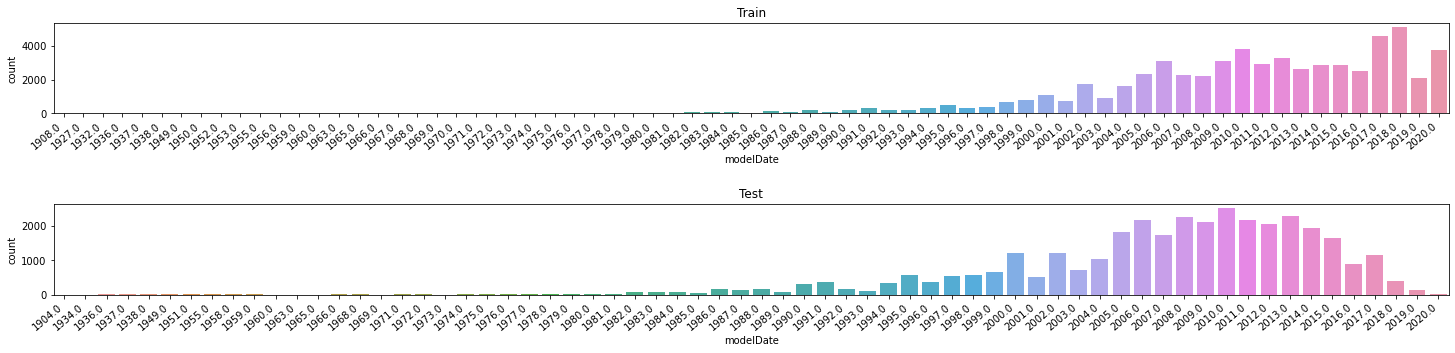

In [33]:
# Let's visualize modelDate.
double_countplot(df_merged, 'modelDate')

## model_name

In [34]:
# Let's replace model_name with UPPERCASE English names 
train = df_merged[df_merged['source']=='train'].copy()
train['model_name'] = train['model_info'].map(lambda x: from_json_str(x, 'code'))
df_merged[df_merged['source']=='train'] = train

# just checking that there are no NaN
df_merged[df_merged['model_name'].isna()]

,bodyType,brand,complectation_dict,equipment_dict,fuelType,modelDate,model_info,model_name,name,numberOfDoors,...,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,color,source


In [35]:
df_merged[df_merged['source']=='train']['model_name'].value_counts()

POLO         1575
FOCUS        1423
RIO          1394
X_TRAIL      1183
QASHQAI      1179
             ... 
NOVA            1
STARCRAFT       1
928             1
AVANTIME        1
AGILA           1
Name: model_name, Length: 849, dtype: int64

## numberOfDoors

In [36]:
# let's check out numberOfDoors - looks like there are no more missing values 
df_merged['numberOfDoors'].value_counts(dropna=False)

5.0    57408
4.0    33288
3.0     2336
2.0     2139
0.0        1
Name: numberOfDoors, dtype: int64

## productionDate

<ipython-input-16-68cb8a68848a>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
<ipython-input-16-68cb8a68848a>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

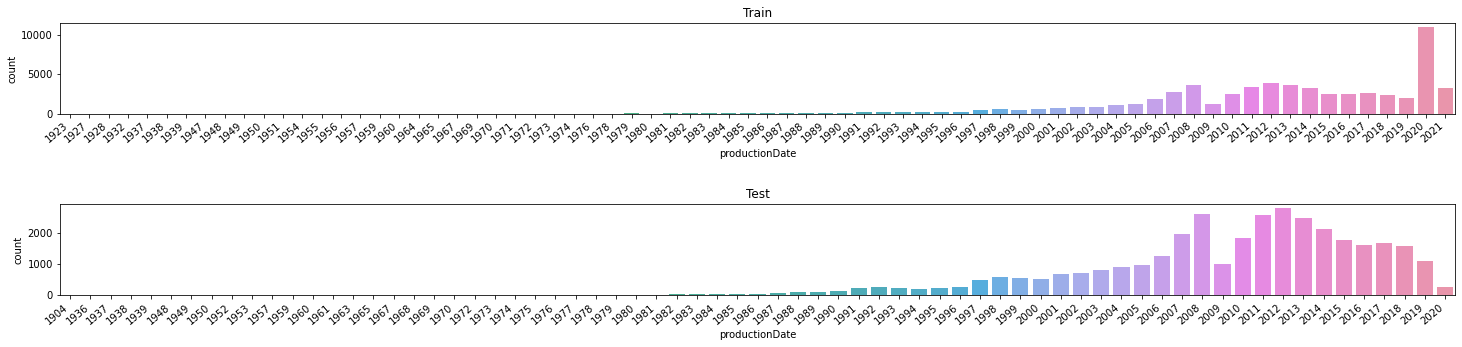

In [37]:
# Let's visualize productionDate. It looks suspiciosly similar to modelDate
double_countplot(df_merged, 'productionDate')

In [38]:
# Looks like only a small part of modelDates equals to productionDates.
# In fact, it makes sense. For example, a model from 2018 can still be in production in 2019 and even 2020.
df_merged[df_merged['modelDate'] == df_merged['productionDate']]

,bodyType,brand,complectation_dict,equipment_dict,fuelType,modelDate,model_info,model_name,name,numberOfDoors,...,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,color,source
1,хэтчбек,FORD,{'id': '0'},{},бензин,1927.0,"{'code': 'MODEL_A', 'name': 'Model A', 'ru_nam...",MODEL_A,3.3 MT (40 л.с.),3.0,...,задний,LEFT,used,1,ORIGINAL,True,"{'year': 2007, 'month': 5}",4300000.0,0000CC,train
3,седан,FORD,{'id': '0'},{},бензин,1932.0,"{'code': 'V8', 'name': 'V8', 'ru_name': 'в8', ...",V8,3.6 MT (66 л.с.),2.0,...,задний,LEFT,used,1,ORIGINAL,True,"{'year': 2014, 'month': 10}",2700000.0,040001,train
4,седан,FORD,{'id': '0'},{},бензин,1932.0,"{'code': 'V8', 'name': 'V8', 'ru_name': 'в8', ...",V8,3.6 MT (66 л.с.),2.0,...,задний,LEFT,used,2,DUPLICATE,True,NaN,580000.0,040001,train
6,седан,BMW,{'id': '0'},"{'condition': True, 'abs': True, 'bluetooth': ...",бензин,1937.0,"{'code': '321', 'name': '321', 'ru_name': '321...",321,2.0 MT (46 л.с.),2.0,...,задний,LEFT,used,3,ORIGINAL,True,NaN,2000000.0,040001,train
7,седан,AUDI,{'id': '0'},{},бензин,1938.0,"{'code': '920', 'name': '920', 'ru_name': '920...",920,3.3 MT (75 л.с.),4.0,...,задний,LEFT,used,2,ORIGINAL,True,"{'year': 1986, 'month': 8}",2000000.0,040001,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34657,купе,BMW,NaN,"{""engine-proof"":true,""asr"":true,""esp"":true,""ai...",дизель,2014.0,"{""code"":""2ER"",""name"":""2 серии"",""ru_name"":""2 се...",2ER,220d 2.0d AT (184 л.с.),2.0,...,задний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,1 год и 8 месяцев,-1.0,синий,test
34672,хэтчбек,BMW,NaN,"{""cruise-control"":true,""asr"":true,""roller-blin...",бензин,2007.0,"{""code"":""1ER"",""name"":""1 серии"",""ru_name"":""1 се...",1ER,130i 3.0 AT (265 л.с.),5.0,...,задний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,5 лет и 10 месяцев,-1.0,чёрный,test
34673,седан,BMW,NaN,NaN,бензин,2005.0,"{""code"":""7ER"",""name"":""7 серии"",""ru_name"":""7 се...",7ER,750Li 4.8 AT (367 л.с.),4.0,...,задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,-1.0,чёрный,test
34676,внедорожник,BMW,NaN,NaN,дизель,2003.0,"{""code"":""X5"",""name"":""X5"",""ru_name"":""Х5"",""morph...",X5,3.0d 3.0d AT (218 л.с.) 4WD,5.0,...,полный,Левый,Не требует ремонта,3 или более,Дубликат,Растаможен,NaN,-1.0,серебристый,test


## vehicleTransmission

In [39]:
# vehicleTransmission has a different language. Let's simply translate it here instead of 
# re-running a web service and trying to figure out where to find Russian name
df_merged.groupby(['source', 'vehicleTransmission']).size()

source  vehicleTransmission
test    автоматическая         19596
        вариатор                3999
        механическая            7209
        роботизированная        3882
train   AUTOMATIC              30681
        MECHANICAL             16990
        ROBOT                   6502
        VARIATOR                6313
dtype: int64

In [40]:
russian_dict = {'AUTOMATIC':'автоматическая', 'MECHANICAL': 'механическая','ROBOT': 'роботизированная', 'VARIATOR': 'вариатор'}
df_merged['vehicleTransmission'] = df_merged['vehicleTransmission'].map(lambda x: translate_by_dict(x, russian_dict))
df_merged.groupby(['source', 'vehicleTransmission']).size()

source  vehicleTransmission
test    автоматическая         19596
        вариатор                3999
        механическая            7209
        роботизированная        3882
train   автоматическая         30681
        вариатор                6313
        механическая           16990
        роботизированная        6502
dtype: int64

## vendor

In [41]:
# Let's look at vendor. It's strange - I removed all the russian brands before crawling auto.ru.
# Need to look closer.
df_merged.groupby(['source', 'vendor']).size()

source  vendor  
test    EUROPEAN    20682
        JAPANESE    14004
train   AMERICAN     5282
        EUROPEAN    28450
        JAPANESE    16847
        KOREAN       9415
        RUSSIAN       492
dtype: int64

In [42]:
# Since when is SUZUKI and CHEVROLET Russian brands??? Looks like a mistake to me. 
df_merged[df_merged['vendor']=='RUSSIAN']['brand'].value_counts()

CHEVROLET    491
SUZUKI         1
Name: brand, dtype: int64

In [43]:
# Dropping erroneous Russian brands
df_merged = df_merged[df_merged['vendor'] != 'RUSSIAN']
df_merged.groupby(['source', 'vendor']).size()

source  vendor  
test    EUROPEAN    20682
        JAPANESE    14004
train   AMERICAN     5282
        EUROPEAN    28450
        JAPANESE    16847
        KOREAN       9415
dtype: int64

## engineDisplacement

In [44]:
# Let's look at engineDisplacement. As seen before, engineDisplacement in test simply needs conversion to numeric.
# However train data needs a propper modification because it's a mess (especially with all the BMW cars and their model naming). 
df_merged.groupby(['source', 'engineDisplacement']).size()

source  engineDisplacement
test     LTR                   55
        0.7 LTR                53
        1.0 LTR                57
        1.1 LTR                 4
        1.2 LTR               485
                             ... 
train   xDrive18d              67
        xDrive20d               3
        xDrive20i              57
        xDrive28i               1
        ТагАЗ                 222
Length: 478, dtype: int64

<ipython-input-16-68cb8a68848a>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
<ipython-input-16-68cb8a68848a>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

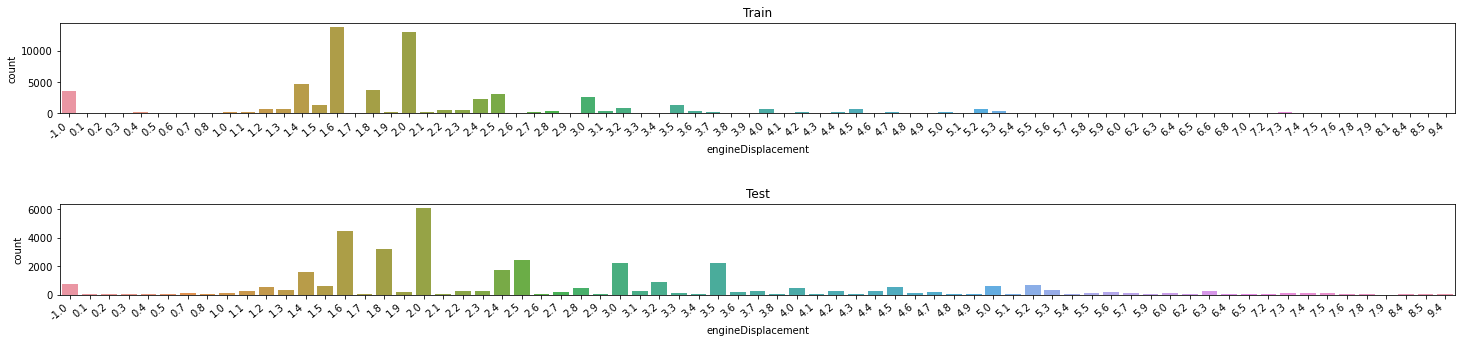

In [45]:
# modifying engineDisplacement.
df_merged['engineDisplacement'] = df_merged['name'].map(lambda x: get_engine_displacement(x))
double_countplot(df_merged, 'engineDisplacement')

In [46]:
# There were some cars with missing engine displacements (or I might have processed it incorrectly in the previous step). They got -1.
# Actually, there might be some electric cars among them. But we have a separate feature for that.
df_merged[df_merged['engineDisplacement']==-1].groupby(['brand', 'engineDisplacement']).size()

brand       engineDisplacement
AUDI        -1.0                  215
BMW         -1.0                  111
CHEVROLET   -1.0                   25
CITROEN     -1.0                  125
FORD        -1.0                   38
HONDA       -1.0                  129
HYUNDAI     -1.0                  284
INFINITI    -1.0                    9
JEEP        -1.0                   16
KIA         -1.0                  297
LEXUS       -1.0                    2
MAZDA       -1.0                   10
MERCEDES    -1.0                   13
MINI        -1.0                  515
MITSUBISHI  -1.0                   77
NISSAN      -1.0                   87
OPEL        -1.0                  298
PEUGEOT     -1.0                   28
PORSCHE     -1.0                  409
RENAULT     -1.0                  906
SKODA       -1.0                  147
SUBARU      -1.0                   22
SUZUKI      -1.0                    7
TOYOTA      -1.0                  354
VOLKSWAGEN  -1.0                  269
VOLVO       -1.0   

## enginePower

In [47]:
# We know that enginePower in test needs N12 removed
test = df_merged[df_merged['source']=='test'].copy()
test['enginePower'] = test['enginePower'].str.split(' ').str[0].astype(float)
df_merged[df_merged['source']=='test'] = test
df_merged['enginePower'].unique()

array([20.0, 40.0, 66.0, 51.0, 46.0, 75.0, 85.0, 86.0, 100.0, 95.0, 92.0,
       68.0, 162.0, 105.0, 335.0, 60.0, 45.0, 365.0, 42.0, 90.0, 150.0,
       155.0, 167.0, 300.0, 52.0, 101.0, 203.0, 89.0, 48.0, 145.0, 124.0,
       107.0, 213.0, 180.0, 70.0, 210.0, 441.0, 200.0, 109.0, 110.0,
       122.0, 115.0, 73.0, 98.0, 170.0, 197.0, 182.0, 130.0, 125.0, 160.0,
       80.0, 139.0, 54.0, 50.0, 136.0, 135.0, 102.0, 310.0, 103.0, 53.0,
       129.0, 44.0, 121.0, 91.0, 78.0, 112.0, 113.0, 218.0, 192.0, 171.0,
       282.0, 190.0, 173.0, 140.0, 120.0, 74.0, 83.0, 72.0, 55.0, 143.0,
       131.0, 117.0, 88.0, 137.0, 188.0, 202.0, 295.0, 128.0, 82.0, 84.0,
       79.0, 211.0, 147.0, 76.0, 69.0, 165.0, 184.0, 169.0, 215.0, 149.0,
       67.0, 94.0, 133.0, 220.0, 278.0, 141.0, 280.0, 230.0, 260.0, 151.0,
       174.0, 172.0, 71.0, 99.0, 116.0, 58.0, 245.0, 225.0, 132.0, 97.0,
       108.0, 111.0, 340.0, 193.0, 205.0, 239.0, 144.0, 177.0, 235.0,
       114.0, 96.0, 233.0, 238.0, 212.0, 154.0, 19

<ipython-input-16-68cb8a68848a>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
<ipython-input-16-68cb8a68848a>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

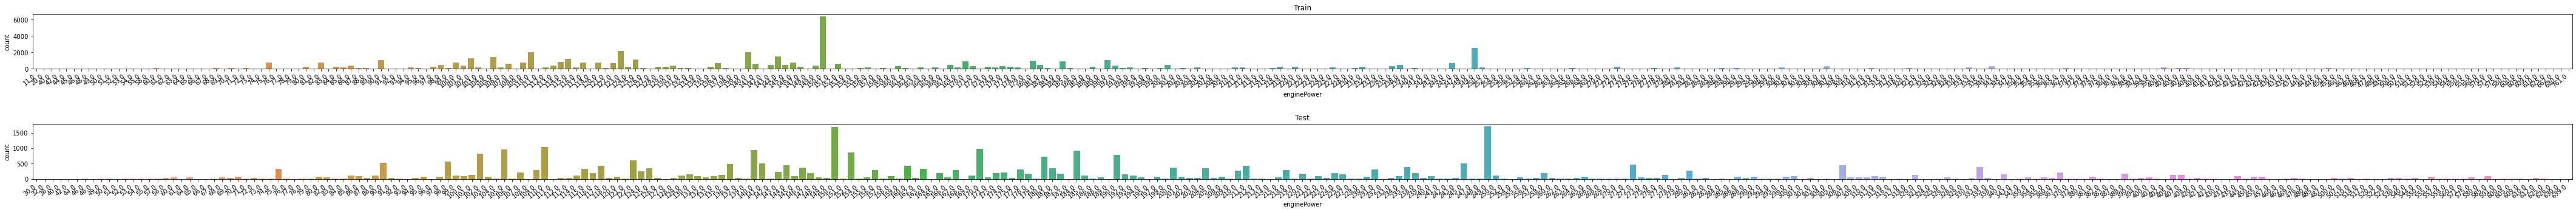

In [48]:
df_merged['enginePower'] = df_merged['enginePower'].astype(float)
double_countplot(df_merged, 'enginePower', 75)

<AxesSubplot:>

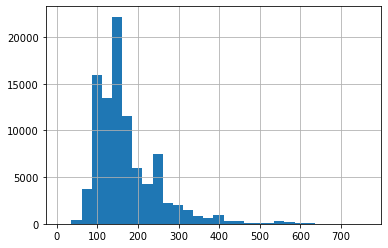

In [49]:
# I don't see anything extraordinary
df_merged['enginePower'].hist(bins=30)

In [50]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94680 entries, 0 to 34685
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              94680 non-null  object 
 1   brand                 94680 non-null  object 
 2   complectation_dict    66412 non-null  object 
 3   equipment_dict        84684 non-null  object 
 4   fuelType              94680 non-null  object 
 5   modelDate             94680 non-null  float64
 6   model_info            94680 non-null  object 
 7   model_name            94680 non-null  object 
 8   name                  94680 non-null  object 
 9   numberOfDoors         94680 non-null  float64
 10  productionDate        94680 non-null  int64  
 11  vehicleConfiguration  94680 non-null  object 
 12  vehicleTransmission   94680 non-null  object 
 13  vendor                94680 non-null  object 
 14  engineDisplacement    94680 non-null  float64
 15  enginePower        

## mileage

<AxesSubplot:>

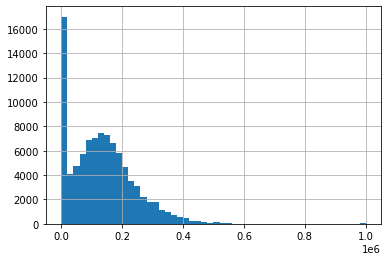

In [51]:
# Let's look at the mileage. 
df_merged['mileage'].hist(bins=50)

In [52]:
# Looks like the distribution is a bit skewed to the right. However, there are also a lot of new cars. No negative mileages - that's good (no error). 
df_merged['mileage'].describe()

count      94680.000000
mean      132887.750306
std       104711.438199
min            0.000000
25%        50529.000000
50%       124667.500000
75%       193000.000000
max      1000000.000000
Name: mileage, dtype: float64

## Привод

In [53]:
# Let's look at Привод
df_merged.groupby(['source', 'Привод']).size()

source  Привод  
test    задний       4101
        передний    15565
        полный      15020
train   задний       2907
        передний    35229
        полный      21858
dtype: int64

## Руль

In [54]:
# Let's look at Руль. Looks like it needs translation
df_merged.groupby(['source', 'Руль']).size()

source  Руль  
test    Левый     33287
        Правый     1399
train   LEFT      58775
        RIGHT      1219
dtype: int64

In [55]:
russian_dict = {'LEFT':'Левый', 'RIGHT': 'Правый'}
df_merged['Руль'] = df_merged['Руль'].map(lambda x: translate_by_dict(x, russian_dict))
df_merged['Руль'] = df_merged['Руль'].str.lower()
df_merged.groupby(['source', 'Руль']).size()

source  Руль  
test    левый     33287
        правый     1399
train   левый     58775
        правый     1219
dtype: int64

## Состояние

In [56]:
# Let's look at Состояние
df_merged.groupby(['source', 'Состояние']).size()

source  Состояние         
test    Не требует ремонта    34686
train   new                   13835
        used                  46159
dtype: int64

In [57]:
# Looks like it's inconsistent and needs dropping
df_merged.drop('Состояние', inplace=True, axis=1)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94680 entries, 0 to 34685
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              94680 non-null  object 
 1   brand                 94680 non-null  object 
 2   complectation_dict    66412 non-null  object 
 3   equipment_dict        84684 non-null  object 
 4   fuelType              94680 non-null  object 
 5   modelDate             94680 non-null  float64
 6   model_info            94680 non-null  object 
 7   model_name            94680 non-null  object 
 8   name                  94680 non-null  object 
 9   numberOfDoors         94680 non-null  float64
 10  productionDate        94680 non-null  int64  
 11  vehicleConfiguration  94680 non-null  object 
 12  vehicleTransmission   94680 non-null  object 
 13  vendor                94680 non-null  object 
 14  engineDisplacement    94680 non-null  float64
 15  enginePower        

## Владельцы

In [58]:
# Let's look at Владельцы
df_merged.groupby(['source', 'Владельцы']).size()

source  Владельцы  
test    1 владелец      9459
        2 владельца     9270
        3 или более    15957
train   1.0            14663
        2.0            12239
        3.0            17975
        4.0             1275
dtype: int64

In [59]:
# There are a lot of missing values and test data needs to be modified. Let's look at the missing values first.
# Looks like most of these missing values actually come from 2020 and 2021 - that makes sense. 
df_merged[df_merged['Владельцы'].isna()].groupby('productionDate').size()

productionDate
1980        1
2000        1
2001        1
2006        2
2007        1
2011        1
2018        5
2019      140
2020    10437
2021     3253
dtype: int64

In [60]:
# I'll be looking at test and train set separately here
test = df_merged[df_merged['source']=='test'].copy()
train = df_merged[df_merged['source']=='train'].copy()

In [61]:
train[train['Владельцы'].isna()].groupby(['productionDate', 'mileage']).size()

productionDate  mileage
1980            100000         1
2000            220000         1
2001            160000         1
2006            87499          1
                179000         1
2007            180000         1
2011            107500         1
2018            0              5
2019            0            140
2020            0          10437
2021            0           3253
dtype: int64

In [62]:
# Looks like mileage is a great attribute to use for filling a part of missing values of Владельцы
tmp = train[(train['Владельцы'].isna()) & (train['mileage']==0)].copy()
tmp['Владельцы'] = 0
train[(train['Владельцы'].isna()) & (train['mileage']==0)] = tmp
train[train['Владельцы']==0].groupby(['productionDate', 'mileage']).size()

productionDate  mileage
2018            0              5
2019            0            140
2020            0          10437
2021            0           3253
dtype: int64

In [63]:
# Let's replace the rest of NaN in train with 1 (at least 1 owner)
train['Владельцы'].fillna(1, inplace=True)

In [64]:
# We know that the number of owners > 3 is put into one group in a test dataset. Let's do the same in train.
train.loc[train['Владельцы'] > 3, 'Владельцы'] = 3
train['Владельцы'].describe()

count    59994.000000
mean         1.615128
std          1.157459
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: Владельцы, dtype: float64

In [65]:
# We don't have missing values in test
test[test['Владельцы'].isna()].groupby(['productionDate', 'mileage']).size()

Series([], dtype: int64)

In [66]:
# What looks weird though is that we don't have new cars in a test set at all
test['Владельцы'].value_counts()

3 или более    15957
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64

In [67]:
# First of all, let's replace string values for Владельцы in test with 1, 2 and 3 
test['Владельцы'] = test['Владельцы'].str[:1].astype(int)
test['Владельцы'].describe()

count    34686.000000
mean         2.187338
std          0.835266
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: Владельцы, dtype: float64

In [68]:
# Let's take a closer look at this issue. There are a lot of cars with 1 or even multiple owners and mileage
# <= 30 km. That doesn't look right.
test[test['mileage']<=30].groupby(['productionDate', 'Владельцы', 'mileage']).size()

productionDate  Владельцы  mileage
1936            1          1          1
1948            3          10         1
2018            1          10         1
2019            1          1          2
                           10         1
                           11         1
                           21         1
                           23         1
                           24         1
                           25         1
                           26         1
                           27         1
                           30         1
2020            1          1          8
                           5          1
                           6          4
                           7          3
                           9          7
                           10         8
                           11         3
                           12         1
                           13         1
                           14         1
                           15         6
     

In [69]:
# I will change a test dataset and replace Владельцы for all the cases where mileage is <= 30 and year >=2018 with 0
tmp = test[(test['mileage']<=30) & (test['productionDate']>=2018)].copy()
tmp['Владельцы'] = 0
test[(test['mileage']<=30) & (test['productionDate']>=2018)] = tmp
test[test['mileage']<=30].groupby(['productionDate', 'Владельцы', 'mileage']).size()

productionDate  Владельцы  mileage
1936            1          1          1
1948            3          10         1
2018            0          10         1
2019            0          1          2
                           10         1
                           11         1
                           21         1
                           23         1
                           24         1
                           25         1
                           26         1
                           27         1
                           30         1
2020            0          1          8
                           5          1
                           6          4
                           7          3
                           9          7
                           10         8
                           11         3
                           12         1
                           13         1
                           14         1
                           15         6
     

In [70]:
# Merging back together
df_merged[df_merged['source']=='train'] = train
df_merged[df_merged['source']=='test'] = test
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94680 entries, 0 to 34685
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              94680 non-null  object 
 1   brand                 94680 non-null  object 
 2   complectation_dict    66412 non-null  object 
 3   equipment_dict        84684 non-null  object 
 4   fuelType              94680 non-null  object 
 5   modelDate             94680 non-null  float64
 6   model_info            94680 non-null  object 
 7   model_name            94680 non-null  object 
 8   name                  94680 non-null  object 
 9   numberOfDoors         94680 non-null  float64
 10  productionDate        94680 non-null  int64  
 11  vehicleConfiguration  94680 non-null  object 
 12  vehicleTransmission   94680 non-null  object 
 13  vendor                94680 non-null  object 
 14  engineDisplacement    94680 non-null  float64
 15  enginePower        

<ipython-input-16-68cb8a68848a>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
<ipython-input-16-68cb8a68848a>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

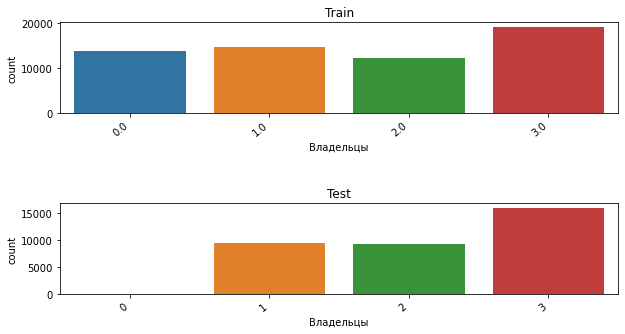

In [71]:
# Fun fact: looks like test dataset still almost doesn't have new cars. Let it be.
double_countplot(df_merged, 'Владельцы', 10)

## ПТС

In [72]:
df_merged.groupby(['source', 'ПТС']).size()

source  ПТС      
test    Дубликат      4587
        Оригинал     30098
train   DUPLICATE     5774
        ORIGINAL     53934
dtype: int64

In [73]:
# let's translate train data
russian_dict = {'DUPLICATE':'Дубликат', 'ORIGINAL': 'Оригинал'}
df_merged['ПТС'] = df_merged['ПТС'].map(lambda x: translate_by_dict(x, russian_dict))
df_merged['ПТС'] = df_merged['ПТС'].str.lower()
df_merged.groupby(['source', 'ПТС']).size()

source  ПТС     
test    other           1
        дубликат     4587
        оригинал    30098
train   other         286
        дубликат     5774
        оригинал    53934
dtype: int64

## Таможня

In [74]:
df_merged.groupby(['source', 'Таможня']).size()

source  Таможня   
test    Растаможен    34686
train   True          59994
dtype: int64

In [75]:
# this feature is useless in our case - let's drop it
df_merged.drop('Таможня', inplace=True, axis=1)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94680 entries, 0 to 34685
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              94680 non-null  object 
 1   brand                 94680 non-null  object 
 2   complectation_dict    66412 non-null  object 
 3   equipment_dict        84684 non-null  object 
 4   fuelType              94680 non-null  object 
 5   modelDate             94680 non-null  float64
 6   model_info            94680 non-null  object 
 7   model_name            94680 non-null  object 
 8   name                  94680 non-null  object 
 9   numberOfDoors         94680 non-null  float64
 10  productionDate        94680 non-null  int64  
 11  vehicleConfiguration  94680 non-null  object 
 12  vehicleTransmission   94680 non-null  object 
 13  vendor                94680 non-null  object 
 14  engineDisplacement    94680 non-null  float64
 15  enginePower        

## Владение

In [76]:
df_merged.groupby(['source', 'Владение']).size()

source  Владение                  
test    1 год                         194
        1 год и 1 месяц               193
        1 год и 10 месяцев            209
        1 год и 11 месяцев            179
        1 год и 2 месяца              187
                                     ... 
train   {'year': 2020, 'month': 6}    173
        {'year': 2020, 'month': 7}    144
        {'year': 2020, 'month': 8}    179
        {'year': 2020, 'month': 9}    151
        {'year': 2021, 'month': 1}     65
Length: 545, dtype: int64

In [77]:
# This one is tricky. First of all, it contains text data. Second of all, it has a lot of missing values.
# This function converts text to duration also deals with NaN values.
df_merged['Владение'] = df_merged.apply(lambda x: ownership_period(x), axis=1)

In [78]:
df_merged['Владение'].describe()

count    94680.000000
mean        24.657615
std         30.251145
min          1.000000
25%         13.000000
50%         13.000000
75%         13.000000
max        789.000000
Name: Владение, dtype: float64

In [79]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94680 entries, 0 to 34685
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              94680 non-null  object 
 1   brand                 94680 non-null  object 
 2   complectation_dict    66412 non-null  object 
 3   equipment_dict        84684 non-null  object 
 4   fuelType              94680 non-null  object 
 5   modelDate             94680 non-null  float64
 6   model_info            94680 non-null  object 
 7   model_name            94680 non-null  object 
 8   name                  94680 non-null  object 
 9   numberOfDoors         94680 non-null  float64
 10  productionDate        94680 non-null  int64  
 11  vehicleConfiguration  94680 non-null  object 
 12  vehicleTransmission   94680 non-null  object 
 13  vendor                94680 non-null  object 
 14  engineDisplacement    94680 non-null  float64
 15  enginePower        

## price

In [80]:
# We have missing 248 missing values for price in our train set. Let's simply get rid of them
df_merged[df_merged['price'].isna()]

,bodyType,brand,complectation_dict,equipment_dict,fuelType,modelDate,model_info,model_name,name,numberOfDoors,...,description,mileage,Привод,Руль,Владельцы,ПТС,Владение,price,color,source
681,седан,VOLKSWAGEN,{'id': '0'},{},бензин,1988.0,"{'code': 'PASSAT', 'name': 'Passat', 'ru_name'...",PASSAT,1.8 MT (90 л.с.),4.0,...,Двигатель откапитален(проехал на нем около 32 ...,352000,передний,левый,3,дубликат,13,NaN,EE1D19,train
750,универсал,BMW,{'id': '0'},"{'steel-wheels': True, 'abs': True, 'roof-rail...",бензин,1987.0,"{'code': '5ER', 'name': '5 серии', 'ru_name': ...",5ER,525i 2.5 AT (192 л.с.),5.0,...,"По документам:птс,стс.Я собственник. Штрафов,з...",300000,задний,левый,3,оригинал,13,NaN,EE1D19,train
846,седан,TOYOTA,{'id': '0'},"{'electro-window-back': True, 'ptf': True, 'us...",бензин,1988.0,"{'code': 'CHASER', 'name': 'Chaser', 'ru_name'...",CHASER,2.0 MT (150 л.с.),4.0,...,Всем привет и с Новым Годом! \nПродам:\nЧайзер...,330000,задний,правый,2,оригинал,13,NaN,FAFBFB,train
1037,седан,TOYOTA,{'id': '0'},"{'electro-window-back': True, 'feedback-alarm'...",дизель,1992.0,"{'code': 'CRESTA', 'name': 'Cresta', 'ru_name'...",CRESTA,2.5d AT (97 л.с.),4.0,...,На полном ходу,312000,задний,правый,3,оригинал,13,NaN,040001,train
1076,универсал,VOLKSWAGEN,{'id': '0'},"{'velvet-seats': True, 'roof-rails': True, '14...",бензин,1991.0,"{'code': 'GOLF', 'name': 'Golf', 'ru_name': 'Г...",GOLF,1.8 MT (75 л.с.),5.0,...,"Продам машину на летних колёсах, для своих лет...",453000,передний,левый,3,дубликат,26,NaN,040001,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48604,внедорожник,HYUNDAI,{'id': '0'},{},бензин,2020.0,"{'code': 'CRETA', 'name': 'Creta', 'ru_name': ...",CRETA,1.6 AT (123 л.с.),5.0,...,NaN,5000,передний,левый,1,оригинал,13,NaN,FAFBFB,train
49669,внедорожник,KIA,{'id': '0'},"{'cruise-control': True, 'esp': True, 'isofix'...",бензин,2018.0,"{'code': 'SPORTAGE', 'name': 'Sportage', 'ru_n...",SPORTAGE,2.0 AT (150 л.с.),5.0,...,"Авто в отличном состоянии без ДТП, покрасов и...",19800,передний,левый,1,оригинал,13,NaN,0000CC,train
50827,универсал,MINI,{'id': '0'},"{'cruise-control': True, '16-inch-wheels': Tru...",бензин,2019.0,"{'code': 'CLUBMAN', 'name': 'Clubman', 'ru_nam...",CLUBMAN,Cooper 1.5 AMT (136 л.с.),5.0,...,Автомобиль приобретён в сентябре 2020 г.\nСост...,3500,передний,левый,1,оригинал,13,NaN,CACECB,train
56036,седан,TOYOTA,"{'id': '21221843', 'name': 'Престиж Safety', '...","{'asr': True, 'tinted-glass': True, 'esp': Tru...",бензин,2017.0,"{'code': 'CAMRY', 'name': 'Camry', 'ru_name': ...",CAMRY,2.5 AT (181 л.с.),4.0,...,ЦЕНА СНИЖЕНА ПО ПРИЧИНЕ НАЛИЧИЯ ИНТЕРЕСУЮЩЕГО ...,3100,передний,левый,1,оригинал,2,NaN,FAFBFB,train


In [81]:
df_merged = df_merged[~df_merged['price'].isna()]
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94432 entries, 0 to 34685
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              94432 non-null  object 
 1   brand                 94432 non-null  object 
 2   complectation_dict    66164 non-null  object 
 3   equipment_dict        84436 non-null  object 
 4   fuelType              94432 non-null  object 
 5   modelDate             94432 non-null  float64
 6   model_info            94432 non-null  object 
 7   model_name            94432 non-null  object 
 8   name                  94432 non-null  object 
 9   numberOfDoors         94432 non-null  float64
 10  productionDate        94432 non-null  int64  
 11  vehicleConfiguration  94432 non-null  object 
 12  vehicleTransmission   94432 non-null  object 
 13  vendor                94432 non-null  object 
 14  engineDisplacement    94432 non-null  float64
 15  enginePower        

## color

In [82]:
# We obviously need to do something with colors in a train set. 
# Unfortunately, webcolor library can't be used for that because most of these colors are not from CSS.
# Luckily we only have 16 hex values to match. I will do that manually using https://encycolorpedia.com/ (using my own impresion of the result).
df_merged.groupby(['source', 'color']).size()

source  color      
test    бежевый          639
        белый           6133
        голубой          457
        жёлтый           194
        зелёный          952
        золотистый       266
        коричневый      1501
        красный         1531
        оранжевый        131
        пурпурный        254
        розовый           13
        серебристый     4113
        серый           3984
        синий           3289
        фиолетовый       219
        чёрный         11010
train   0000CC          5979
        007F00          1614
        040001         14496
        200204          2802
        22A0F8           972
        4A2197           306
        660099           339
        97948F          8252
        C49648          1470
        CACECB          6829
        DEA522           365
        EE1D19          3401
        FAFBFB         12002
        FF8649           450
        FFC0CB            14
        FFD600           455
dtype: int64

In [83]:
colors = {'0000CC' : 'синий', '007F00' : 'зелёный', '040001' : 'чёрный', '200204' : 'красный', '22A0F8' : 'голубой'
          , '4A2197' : 'пурпурный',  '660099' : 'фиолетовый', '97948F' : 'серый', 'C49648' : 'коричневый', 'CACECB' : 'серебристый'
          , 'DEA522' : 'бежевый', 'EE1D19' : 'красный', 'FAFBFB' : 'белый', 'FF8649' : 'оранжевый', 'FFC0CB' : 'розовый', 'FFD600' : 'жёлтый'}
colors

{'0000CC': 'синий',
 '007F00': 'зелёный',
 '040001': 'чёрный',
 '200204': 'красный',
 '22A0F8': 'голубой',
 '4A2197': 'пурпурный',
 '660099': 'фиолетовый',
 '97948F': 'серый',
 'C49648': 'коричневый',
 'CACECB': 'серебристый',
 'DEA522': 'бежевый',
 'EE1D19': 'красный',
 'FAFBFB': 'белый',
 'FF8649': 'оранжевый',
 'FFC0CB': 'розовый',
 'FFD600': 'жёлтый'}

In [84]:
df_merged['color'] = df_merged['color'].map(lambda x: colors.get(x) if colors.get(x) else x)
df_merged.groupby(['source', 'color']).size()

source  color      
test    бежевый          639
        белый           6133
        голубой          457
        жёлтый           194
        зелёный          952
        золотистый       266
        коричневый      1501
        красный         1531
        оранжевый        131
        пурпурный        254
        розовый           13
        серебристый     4113
        серый           3984
        синий           3289
        фиолетовый       219
        чёрный         11010
train   бежевый          365
        белый          12002
        голубой          972
        жёлтый           455
        зелёный         1614
        коричневый      1470
        красный         6203
        оранжевый        450
        пурпурный        306
        розовый           14
        серебристый     6829
        серый           8252
        синий           5979
        фиолетовый       339
        чёрный         14496
dtype: int64

<ipython-input-16-68cb8a68848a>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
<ipython-input-16-68cb8a68848a>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

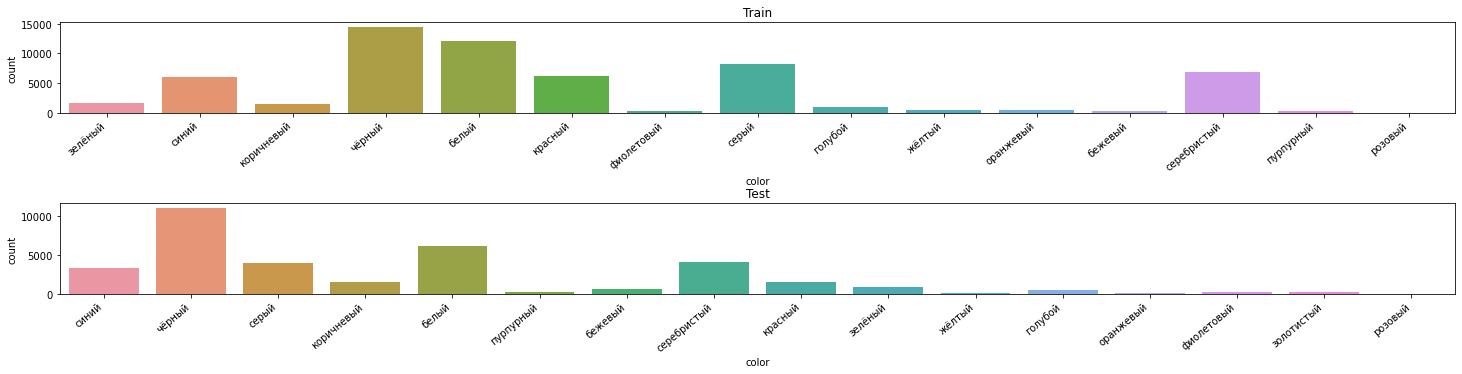

In [85]:
double_countplot(df_merged, 'color')

In [86]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94432 entries, 0 to 34685
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              94432 non-null  object 
 1   brand                 94432 non-null  object 
 2   complectation_dict    66164 non-null  object 
 3   equipment_dict        84436 non-null  object 
 4   fuelType              94432 non-null  object 
 5   modelDate             94432 non-null  float64
 6   model_info            94432 non-null  object 
 7   model_name            94432 non-null  object 
 8   name                  94432 non-null  object 
 9   numberOfDoors         94432 non-null  float64
 10  productionDate        94432 non-null  int64  
 11  vehicleConfiguration  94432 non-null  object 
 12  vehicleTransmission   94432 non-null  object 
 13  vendor                94432 non-null  object 
 14  engineDisplacement    94432 non-null  float64
 15  enginePower        

# Feature engineering

## descriptionLength

<AxesSubplot:>

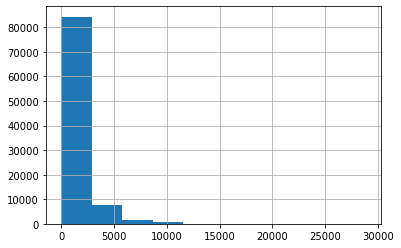

In [87]:
# The most obvious feature that comes to my mind when looking at description
df_merged['descriptionLength'] = df_merged['description'].str.len()
df_merged['descriptionLength'].fillna(0, inplace=True)
df_merged['descriptionLength'].hist(bins=10)

In [88]:
# no missing values - that's good
df_merged[df_merged['descriptionLength'].isna()]

,bodyType,brand,complectation_dict,equipment_dict,fuelType,modelDate,model_info,model_name,name,numberOfDoors,...,mileage,Привод,Руль,Владельцы,ПТС,Владение,price,color,source,descriptionLength


## officialDealerMentioned

In [89]:
# is official dealer mentioned in description?
df_merged['officialDealerMentioned'] = df_merged['description'].str.lower().str.contains('официальн.*дилер')
df_merged['officialDealerMentioned'].fillna(False, inplace=True)
df_merged.groupby(['source', 'officialDealerMentioned']).size()

source  officialDealerMentioned
test    False                      28955
        True                        5731
train   False                      47211
        True                       12535
dtype: int64

Average price values : officialDealerMentioned
False    7.947188e+05
True     1.152277e+06
Name: price, dtype: float64


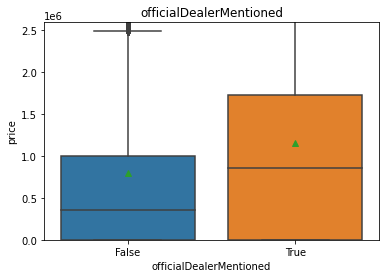

In [90]:
mass_box(df_merged, ['officialDealerMentioned'])

## equipmentDictLength

In [91]:
# This feature will show how many positions are available in equipment dictionary
df_merged['equipmentDictLength'] = df_merged['equipment_dict'].map(lambda x: len(list(df_cell_json(x).keys())) if df_cell_json(x) else 0)

<AxesSubplot:>

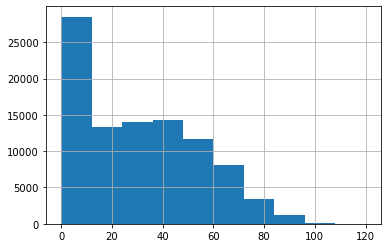

In [92]:
df_merged['equipmentDictLength'].hist()

In [93]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94432 entries, 0 to 34685
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bodyType                 94432 non-null  object 
 1   brand                    94432 non-null  object 
 2   complectation_dict       66164 non-null  object 
 3   equipment_dict           84436 non-null  object 
 4   fuelType                 94432 non-null  object 
 5   modelDate                94432 non-null  float64
 6   model_info               94432 non-null  object 
 7   model_name               94432 non-null  object 
 8   name                     94432 non-null  object 
 9   numberOfDoors            94432 non-null  float64
 10  productionDate           94432 non-null  int64  
 11  vehicleConfiguration     94432 non-null  object 
 12  vehicleTransmission      94432 non-null  object 
 13  vendor                   94432 non-null  object 
 14  engineDisplacement    

## features from equipment_dict

In [94]:
# Let's create a counter with all the equipment available in all the equipment dictionaries
all_equipment = Counter()
for row in df_merged.itertuples():
    try:
        json_acceptable_string = row.equipment_dict.replace("'", "\"")
        json_acceptable_string = json_acceptable_string.replace("True", "\"True\"")
        for i in list(json.loads(json_acceptable_string).keys()):
            all_equipment[i] += 1
    except AttributeError:
        continue
print(all_equipment)

Counter({'lock': 65286, 'abs': 64195, 'electro-mirrors': 58935, 'computer': 56142, 'airbag-driver': 55457, 'electro-window-front': 54486, 'airbag-passenger': 53635, 'front-seats-heat': 53145, 'immo': 52547, 'ptf': 49609, 'mirrors-heat': 46034, 'electro-window-back': 45910, 'usb': 45366, 'esp': 44742, 'wheel-power': 43861, 'aux': 43368, 'multi-wheel': 43128, 'wheel-configuration1': 43120, 'wheel-leather': 43051, 'airbag-side': 43004, '12v-socket': 41665, 'bluetooth': 40394, 'front-centre-armrest': 40264, 'isofix': 37774, 'seat-transformation': 37463, 'cruise-control': 36756, 'light-sensor': 36703, 'rain-sensor': 36174, 'wheel-configuration2': 34689, 'tinted-glass': 33672, 'audiosystem-cd': 33181, 'alloy-wheel-disks': 32606, 'fabric-seats': 30347, 'park-assist-r': 30021, 'dark-interior': 29797, 'leather-gear-stick': 29040, 'airbag-curtain': 28925, 'asr': 28580, 'auto-mirrors': 28426, 'third-rear-headrest': 27557, 'alarm': 27150, 'light-cleaner': 26797, 'automatic-lighting-control': 25986

In [95]:
# Number of unique pieces of equipment
len(all_equipment)

305

In [96]:
# Let's see if top 20 pieces of equipment actualy affect the price in some way
temp = df_merged[df_merged['source']=='train'][['equipment_dict', 'price']].copy()

for i in all_equipment.most_common(20):
    temp[f"has_{i[0]}"] = temp['equipment_dict'].map(lambda x: 1 if i[0] in list(df_cell_json(x).keys()) else 0)                                                        
    
temp

,equipment_dict,price,has_lock,has_abs,has_electro-mirrors,has_computer,has_airbag-driver,has_electro-window-front,has_airbag-passenger,has_front-seats-heat,...,has_mirrors-heat,has_electro-window-back,has_usb,has_esp,has_wheel-power,has_aux,has_multi-wheel,has_wheel-configuration1,has_wheel-leather,has_airbag-side
0,{},3800000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,{},4300000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,{},3350000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,{},2700000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,{},580000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60483,"{'asr': True, 'esp': True, 'usb': True, 'multi...",4270000.0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
60484,"{'cruise-control': True, 'asr': True, 'esp': T...",4022000.0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
60485,"{'cruise-control': True, 'asr': True, 'esp': T...",3872000.0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
60486,"{'asr': True, 'esp': True, 'usb': True, 'multi...",4994000.0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1


In [97]:
temp.describe()

,price,has_lock,has_abs,has_electro-mirrors,has_computer,has_airbag-driver,has_electro-window-front,has_airbag-passenger,has_front-seats-heat,has_immo,...,has_mirrors-heat,has_electro-window-back,has_usb,has_esp,has_wheel-power,has_aux,has_multi-wheel,has_wheel-configuration1,has_wheel-leather,has_airbag-side
count,5.974600e+04,59746.000000,59746.000000,59746.000000,59746.000000,59746.000000,59746.000000,59746.000000,59746.000000,59746.000000,...,59746.000000,59746.000000,59746.000000,59746.000000,59746.000000,59746.000000,59746.000000,59746.000000,59746.000000,59746.000000
mean,1.365415e+06,0.738794,0.726944,0.671928,0.647073,0.632779,0.620226,0.609882,0.599605,0.612777,...,0.537157,0.513206,0.542647,0.512068,0.494075,0.484099,0.503816,0.511432,0.493272,0.474258
std,1.540523e+06,0.439296,0.445533,0.469515,0.477884,0.482052,0.485335,0.487781,0.489983,0.487119,...,0.498622,0.499830,0.498182,0.499859,0.499969,0.499751,0.499990,0.499873,0.499959,0.499341
min,2.000000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.700000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000e+05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.720000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,5.960435e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
temp.drop('equipment_dict', inplace=True, axis=1)

In [99]:
cols = list(temp.columns)
cols.remove('price')
cols

['has_lock',
 'has_abs',
 'has_electro-mirrors',
 'has_computer',
 'has_airbag-driver',
 'has_electro-window-front',
 'has_airbag-passenger',
 'has_front-seats-heat',
 'has_immo',
 'has_ptf',
 'has_mirrors-heat',
 'has_electro-window-back',
 'has_usb',
 'has_esp',
 'has_wheel-power',
 'has_aux',
 'has_multi-wheel',
 'has_wheel-configuration1',
 'has_wheel-leather',
 'has_airbag-side']

Average price values : has_lock
0    8.005324e+05
1    1.565133e+06
Name: price, dtype: float64


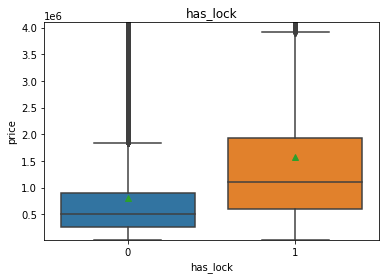

Average price values : has_abs
0    7.554871e+05
1    1.594517e+06
Name: price, dtype: float64


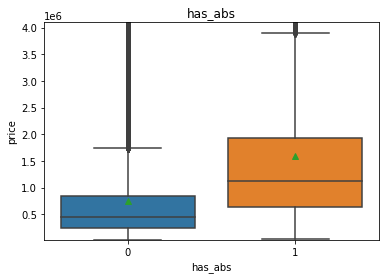

Average price values : has_electro-mirrors
0    7.805501e+05
1    1.650978e+06
Name: price, dtype: float64


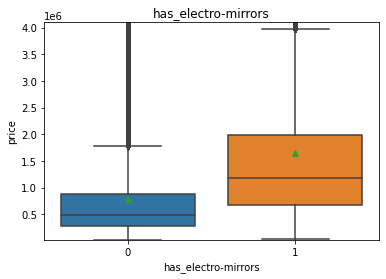

Average price values : has_computer
0    7.251666e+05
1    1.714620e+06
Name: price, dtype: float64


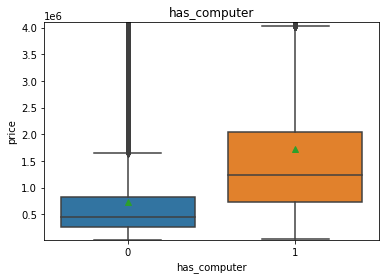

Average price values : has_airbag-driver
0    8.058732e+05
1    1.690134e+06
Name: price, dtype: float64


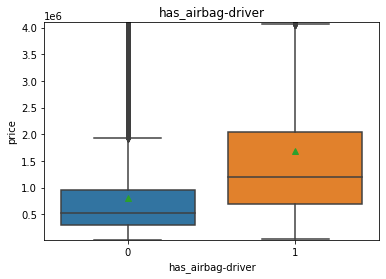

Average price values : has_electro-window-front
0    8.539571e+05
1    1.678589e+06
Name: price, dtype: float64


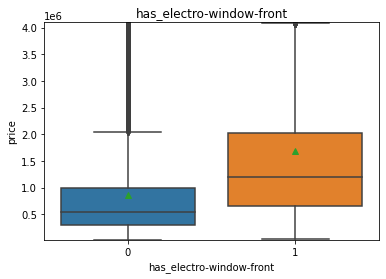

Average price values : has_airbag-passenger
0    7.898977e+05
1    1.733551e+06
Name: price, dtype: float64


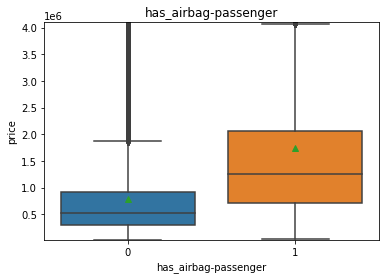

Average price values : has_front-seats-heat
0    7.885305e+05
1    1.750638e+06
Name: price, dtype: float64


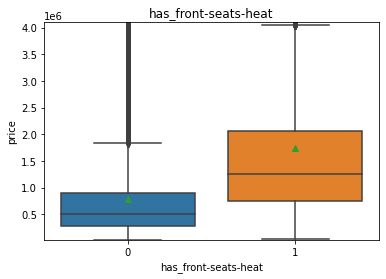

Average price values : has_immo
0    8.173380e+05
1    1.711752e+06
Name: price, dtype: float64


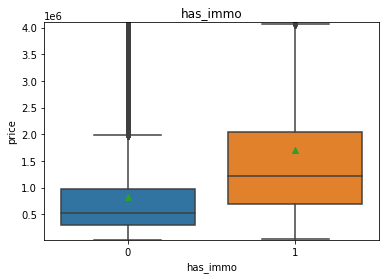

Average price values : has_ptf
0    1.063470e+06
1    1.602815e+06
Name: price, dtype: float64


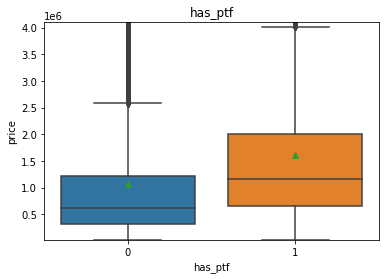

Average price values : has_mirrors-heat
0    8.666117e+05
1    1.795210e+06
Name: price, dtype: float64


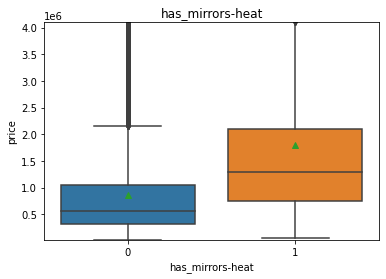

Average price values : has_electro-window-back
0    8.944488e+05
1    1.812143e+06
Name: price, dtype: float64


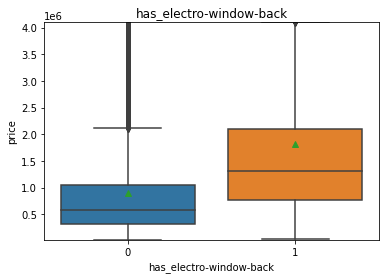

Average price values : has_usb
0    7.941649e+05
1    1.846875e+06
Name: price, dtype: float64


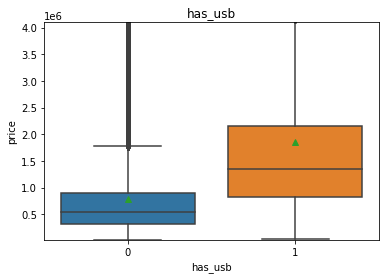

Average price values : has_esp
0    8.087230e+05
1    1.895868e+06
Name: price, dtype: float64


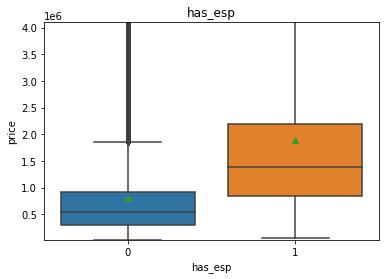

Average price values : has_wheel-power
0    1.581946e+06
1    1.143690e+06
Name: price, dtype: float64


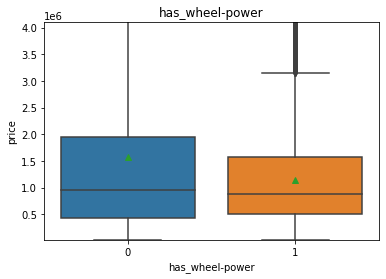

Average price values : has_aux
0    1.034529e+06
1    1.718038e+06
Name: price, dtype: float64


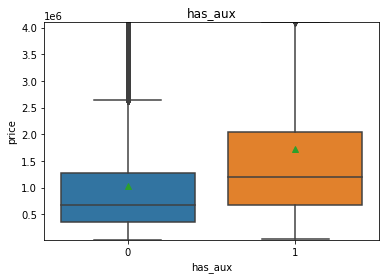

Average price values : has_multi-wheel
0    7.556280e+05
1    1.965964e+06
Name: price, dtype: float64


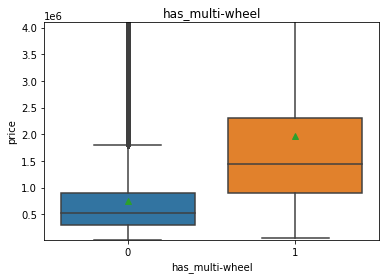

Average price values : has_wheel-configuration1
0    1.106461e+06
1    1.612792e+06
Name: price, dtype: float64


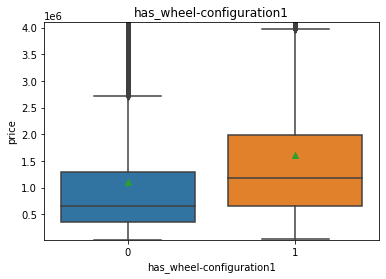

Average price values : has_wheel-leather
0    7.860416e+05
1    1.960594e+06
Name: price, dtype: float64


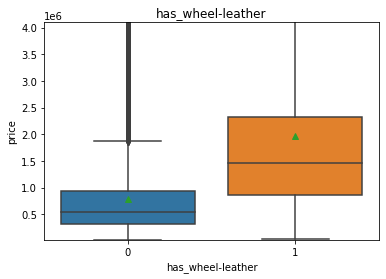

Average price values : has_airbag-side
0    8.094439e+05
1    1.981741e+06
Name: price, dtype: float64


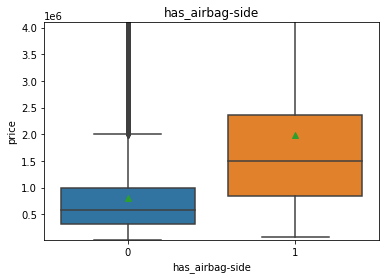

In [100]:
# SCROLL DOWN to see all the results
# It seems that all the features from top 20 except for has_wheel-power might make some difference.
mass_box(temp, cols)

In [101]:
# let's add these features to df_merged
cols.remove('has_wheel-power')
for i in cols:
    df_merged[i] = df_merged['equipment_dict'].map(lambda x: 1 if i in list(df_cell_json(x).keys()) else 0)    

In [102]:
# dropping columns that we do not require anymore
df_merged.drop(labels=['complectation_dict', 'equipment_dict', 'description', 'vehicleConfiguration', 'name', 'model_info'], inplace=True, axis=1)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94432 entries, 0 to 34685
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bodyType                  94432 non-null  object 
 1   brand                     94432 non-null  object 
 2   fuelType                  94432 non-null  object 
 3   modelDate                 94432 non-null  float64
 4   model_name                94432 non-null  object 
 5   numberOfDoors             94432 non-null  float64
 6   productionDate            94432 non-null  int64  
 7   vehicleTransmission       94432 non-null  object 
 8   vendor                    94432 non-null  object 
 9   engineDisplacement        94432 non-null  float64
 10  enginePower               94432 non-null  float64
 11  mileage                   94432 non-null  int64  
 12  Привод                    94432 non-null  object 
 13  Руль                      94432 non-null  object 
 14  Владел

## Additional checks 

In [103]:
df_merged['Владельцы'] = df_merged['Владельцы'].astype(int)
df_merged['officialDealerMentioned'] = df_merged['officialDealerMentioned'].astype(int)

In [104]:
# I think we can tread productionDate and modelDate as numerics here
num_cols = ['modelDate', 'productionDate', 'engineDisplacement', 'enginePower', 'mileage', 'Владение', 'price', 'descriptionLength', 'equipmentDictLength', 'numberOfDoors', 'Владельцы']
cat_cols = []
bin_cols = []

for i, c in enumerate(df_merged.dtypes.index):
    t = df_merged.dtypes.values[i]
    if (t == 'int64') and (c not in num_cols):
        bin_cols.append(c)
    elif (t == 'object'):
        cat_cols.append(c)

print(f"Numeric columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")
print(f"Binary columns: {bin_cols}")

Numeric columns: ['modelDate', 'productionDate', 'engineDisplacement', 'enginePower', 'mileage', 'Владение', 'price', 'descriptionLength', 'equipmentDictLength', 'numberOfDoors', 'Владельцы']
Categorical columns: ['bodyType', 'brand', 'fuelType', 'model_name', 'vehicleTransmission', 'vendor', 'Привод', 'Руль', 'ПТС', 'color', 'source']
Binary columns: ['has_lock', 'has_abs', 'has_electro-mirrors', 'has_computer', 'has_airbag-driver', 'has_electro-window-front', 'has_airbag-passenger', 'has_front-seats-heat', 'has_immo', 'has_ptf', 'has_mirrors-heat', 'has_electro-window-back', 'has_usb', 'has_esp', 'has_aux', 'has_multi-wheel', 'has_wheel-configuration1', 'has_wheel-leather', 'has_airbag-side']


<AxesSubplot:>

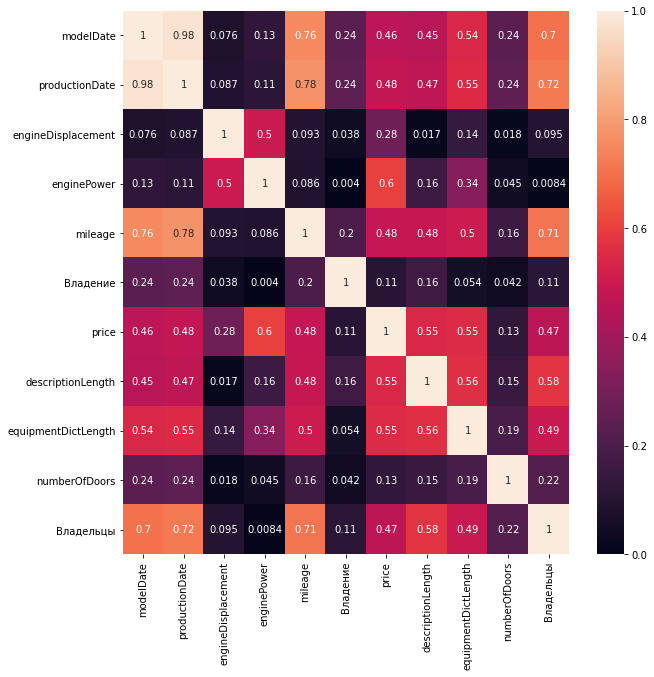

In [105]:
# Correlation matrix shows a rather weak correlation between price and (Владение, numberOfDoors).
# I won't get rid of these variable sright away, but I might later.

# Some variables correlate with each other (like for example modelDate and productionDate), but that should not be a problem
# for the algorithms I will be using.
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_merged[df_merged['source']=='train'][num_cols].corr().abs(), vmin=0, vmax=1, annot=True, ax=ax)

## Label Encoding

In [106]:
# source allows to differentiate between test and train
data = df_merged.copy()
data.reset_index(drop=True, inplace=True) 
data.groupby('source').size()

source
test     34686
train    59746
dtype: int64

In [107]:
# let's try without most of bin_cols just for fun
data.drop(labels=['has_lock', 'has_abs', 'has_electro-mirrors', 'has_computer', 'has_airbag-driver', 'has_electro-window-front', 'has_airbag-passenger', 'has_front-seats-heat', 'has_immo', 'has_ptf', 'has_mirrors-heat', 'has_electro-window-back', 'has_usb', 'has_esp', 'has_aux', 'has_multi-wheel', 'has_wheel-configuration1', 'has_wheel-leather', 'has_airbag-side'], inplace=True, axis=1)

In [108]:
cat_cols.remove('source')
num_cols.remove('price')

In [109]:
# saving the dictionary of categories to be able to access them by name and index if required
cat_dict = {}
for column in cat_cols:
    data[column] = data[column].astype('category')
    cat_dict[column] = data[column].cat.categories
    data[column] = data[column].cat.codes

In [110]:
data

,bodyType,brand,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,vendor,engineDisplacement,...,Руль,Владельцы,ПТС,Владение,price,color,source,descriptionLength,officialDealerMentioned,equipmentDictLength
0,1,4,0,1908.0,557,2.0,1923,2,0,2.9,...,0,1,2,13,3800000.0,4,train,395.0,0,0
1,17,4,0,1927.0,556,3.0,1927,2,0,3.3,...,0,1,2,167,4300000.0,13,train,149.0,0,0
2,17,4,0,1927.0,556,3.0,1928,2,0,3.3,...,0,1,2,13,3350000.0,6,train,71.0,0,0
3,11,4,0,1932.0,855,2.0,1932,2,0,3.6,...,0,1,2,77,2700000.0,15,train,210.0,0,0
4,11,4,0,1932.0,855,2.0,1932,2,0,3.6,...,0,2,1,13,580000.0,15,train,143.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94427,11,1,0,2011.0,43,4.0,2014,0,1,3.1,...,0,3,2,25,-1.0,6,test,414.0,1,42
94428,11,1,3,2016.0,58,4.0,2018,0,1,5.2,...,0,1,2,13,-1.0,15,test,30.0,0,0
94429,11,1,0,1995.0,58,4.0,1997,0,1,5.2,...,0,3,1,13,-1.0,12,test,17.0,0,0
94430,0,1,3,2012.0,909,5.0,2013,0,1,2.0,...,0,2,2,13,-1.0,6,test,596.0,1,45


In [111]:
cat_dict

{'bodyType': Index(['внедорожник', 'кабриолет', 'компактвэн', 'купе', 'купе-хардтоп',
        'лимузин', 'лифтбек', 'микровэн', 'минивэн', 'пикап', 'родстер',
        'седан', 'седан-хардтоп', 'тарга', 'универсал', 'фастбек', 'фургон',
        'хэтчбек'],
       dtype='object'),
 'brand': Index(['AUDI', 'BMW', 'CHEVROLET', 'CITROEN', 'FORD', 'HONDA', 'HYUNDAI',
        'INFINITI', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MERCEDES', 'MINI',
        'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
        'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO'],
       dtype='object'),
 'fuelType': Index(['бензин', 'газ', 'гибрид', 'дизель', 'электро'], dtype='object'),
 'model_name': Index(['02', '100', '1007', '100NX', '100_SERIES', '106', '107', '120', '1200',
        '121',
        ...
        'YETI', 'Z', 'Z1', 'Z3', 'Z3M', 'Z4', 'ZAFIRA', 'ZAFIRA_LIFE', 'ZEPHYR',
        'ZEST'],
       dtype='object', length=948),
 'vehicleTransmission': Index(['автоматическая', 'вар

In [112]:
y = data.query('source == "train"')['price']
X = data.query('source == "train"').drop(['source', 'price'], axis=1)
X_sub = data.query('source == "test"').drop(['source', 'price'], axis=1)

## Train Split

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [114]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [115]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Ошибка наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Ошибка наивной модели по метрике MAPE: 95.96%


# IMPORTANT: models below might take a long time to train. That's why I commented out all of them except the one I used for the final submission. Each model has a comment that explains why was it commented out or left uncommented! #

# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

**Very good model, but the one with logarithm appliet to target variable is better (see below). That's why this one is commented out: Ошибка модели по метрике MAPE: 11.45%**

In [116]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train, y_train,
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# model.save_model('catboost_single_model_baseline.model')

In [117]:
# # оцениваем точность
# predict = model.predict(X_test)
# print(f"Ошибка модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [118]:
np.log(y_train)

20070    13.383188
41801    13.527828
55207    14.485901
38161    13.978479
33470    13.102161
           ...    
54343    14.396811
38158    14.503645
860      11.775290
15795    13.081541
56422    15.263629
Name: price, Length: 47796, dtype: float64

**Very good model, but other algorithm (DecisionTrees) worked slightly better (see "Own models" section below below). CatBoost showed MAPE = 10.09% on train data, but the result on a leaderboard was weaker than DecisionTrees from my models. That's why I commented CatBoost out as well.**

In [119]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train, np.log(y_train),
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# model.save_model('catboost_single_model_2_baseline.model')

In [120]:
# predict_test = np.exp(model.predict(X_test))
# predict_submission = np.exp(model.predict(X_sub))
# print(f"Ошибка модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

# Own models

## Model 3 (decision tree regressor)

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

**Decision Tree result without hyperparameter tuning was OK, but still not as good as CatBoost. Commenting it out, because: Ошибка модели по метрике MAPE: 15.41%**

In [122]:
# The most basic approach (no hyperparameters)

# dt = DecisionTreeRegressor(random_state=RANDOM_SEED)
# dt.fit(X_train, np.log(y_train))
# dt_predict = dt.predict(X_test)

# predict_test = np.exp(dt.predict(X_test))
# predict_submission = np.exp(dt.predict(X_sub))

# print(f"Ошибка модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

**I commented out the result below as well because with hyperparameters it got even weaker results: Ошибка модели по метрике MAPE: 20.85%**

In [123]:
# Kaggle notebook fails when trying to execute this code. I did it on my PC (took a couple of hours) and got the hyperparameters (please see next cell)

# # Let's try some hyperparameters
# param_grid = {"criterion": ["mse", "mae"],
#               "min_samples_split": [10, 20, 40],
#               "max_depth": [2, 6, 8],
#               "min_samples_leaf": [20, 40, 100],
#               "max_leaf_nodes": [5, 20, 100],
#               }

# # Creating a search grid with 5-fold cross-validation based on a previously defined grid
# clf = GridSearchCV(dt, param_grid, cv=5, verbose=0, scoring='neg_mean_absolute_error', n_jobs=-1)

# best_model = clf.fit(X_train_log, np.log(y_train))

In [124]:
# Please see comments from a previous cell
# It wasn't worth it anyway - got even worse result

# dt = DecisionTreeRegressor(criterion='mae', max_depth=8, max_leaf_nodes=100, min_samples_leaf=40,
#                            random_state=RANDOM_SEED, min_samples_split=10)
# dt.fit(X_train, np.log(y_train))
# dt_predict = dt.predict(X_test)

# predict_test = np.exp(dt.predict(X_test))
# predict_submission = np.exp(dt.predict(X_sub))

# print(f"Ошибка модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

## Model 4 ensemble (bagging regressor or random forrest)

In [125]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

**BaggingRegressor took a very long time to train and provided a weak result: Ошибка модели по метрике MAPE: 25.98%. Tried n_estimators = 1000 on my PC as well (on kaggle 1000 was too much), but the result wasn't good either. Commenting it out.**

In [126]:
# max_feat = round(np.sqrt(X_train.shape[1]))
# br = BaggingRegressor(base_estimator=dt, n_estimators=100, max_features=int(max_feat), random_state=RANDOM_SEED)
# br.fit(X_train, np.log(y_train))
# br_predict = br.predict(X_test)

# predict_test = np.exp(br.predict(X_test))
# predict_submission = np.exp(br.predict(X_sub))

# print(f"Ошибка модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

**Even though MAPE for RandomForestRegressor is 10.27%, it actually showed the best result on the leaderboard (15.53886) comparing to other models I used. That's why I will leave this one uncommented and consider it my final result. Please see the rest of the notebook for further attempts and comments.**

In [127]:
rf = RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=2000)
rf.fit(X_train, np.log(y_train))
rf_predict = rf.predict(X_test)

predict_test = np.exp(rf.predict(X_test))
predict_submission = np.exp(rf.predict(X_sub))

print(f"Ошибка модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Ошибка модели по метрике MAPE: 10.27%


## Additional experiments with Random ForestRegressor

**1) I tried experimenting with the most important features (top 10, top 15), but the result was always better on all of the feature set.**

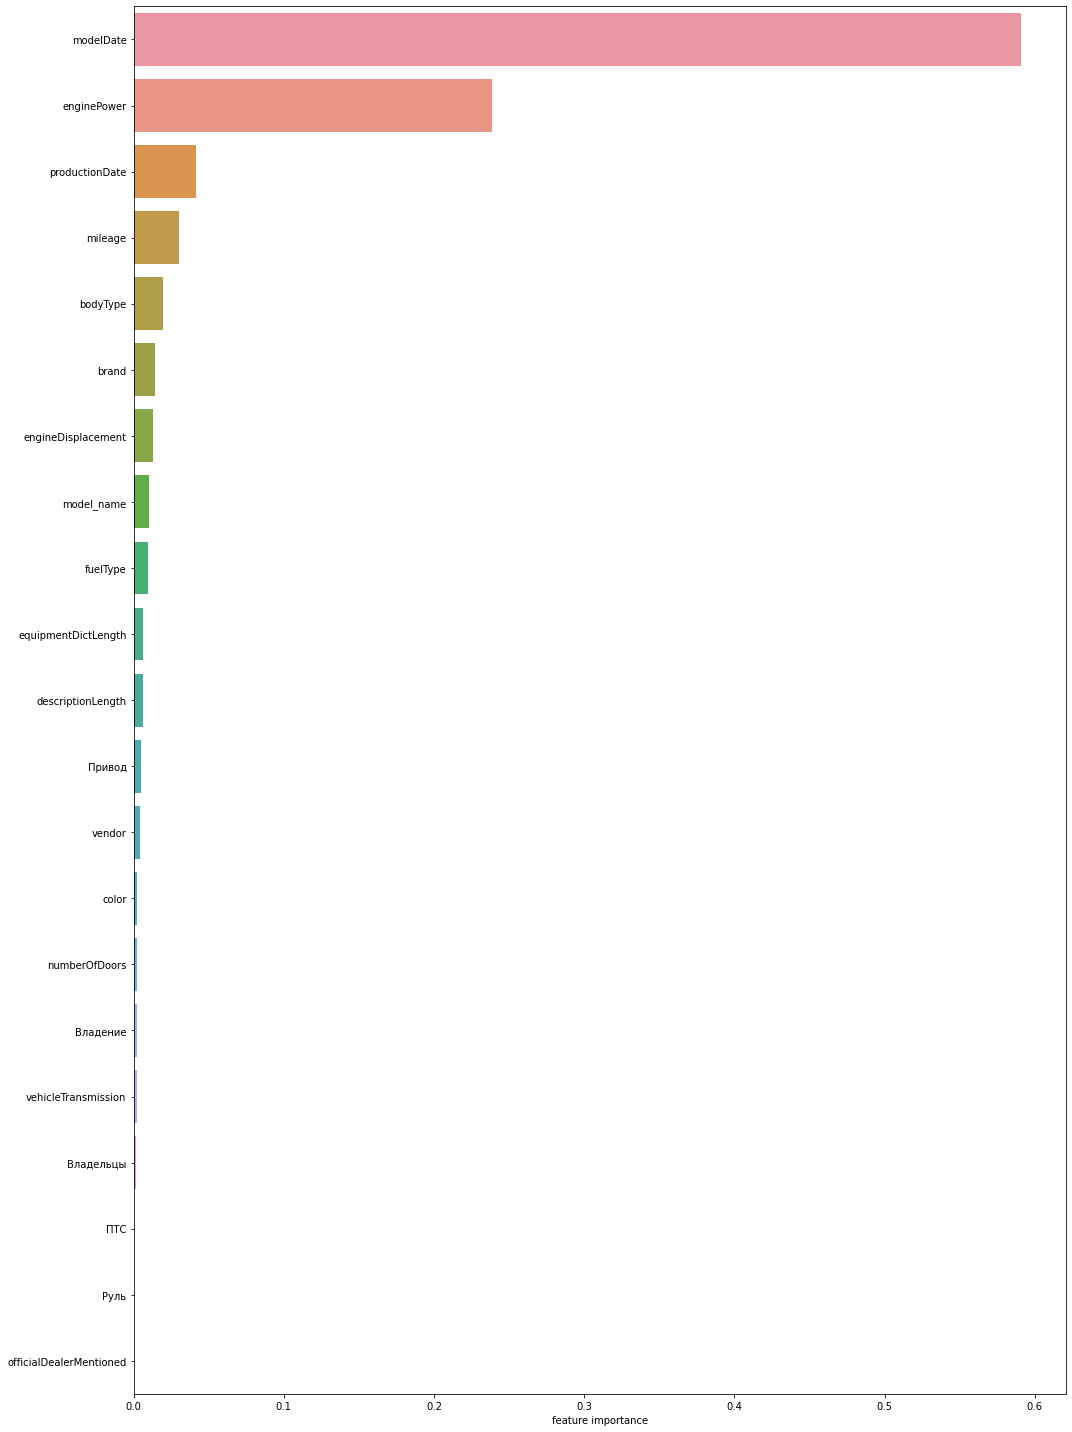

In [128]:
ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(15, 20))
sns.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()

**2) I also tried to do some hyperparameter tuning, but the job took more than 24 hours and still didn't return the result. Either I did something wrong or RandomForrestRegressor is too greedy for resources (I guess both statements are correct :) ). Below is an example of what I tried to do with hyperparameters. It's here only for reference - please don't try to execute it - it will take forever or even fail.**

In [129]:
# # Let's try hyperparameters for RandomForest
# param_grid = {
#     'bootstrap': [True, False],
#     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': [1, 2, 4],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 4000]
# }

# rf = RandomForestRegressor(random_state=RANDOM_SEED)

# # Creating a search grid with 5-fold cross-validation based on a previously defined grid
# clf = GridSearchCV(rf, param_grid, cv=5, verbose=0, scoring='neg_mean_absolute_error', n_jobs=-1)

# best_model = clf.fit(X_train, np.log(y_train))

# best_parameters = best_model.best_estimator_.get_params()
# for param_name in sorted(best_parameters.keys()):
#         print('\t%s: %r' % (param_name, best_parameters[param_name]))

## Model 5 (attempt to stack)

In [130]:
from sklearn.ensemble import StackingRegressor

**Stacking didn't improve the result and it was painfully slow. That's why it's commented out. In fact, RandomForestRegressor with n_estimators=2000 failed to execute on kaggle due to memory restrictions.**

In [131]:
# rf = RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=1000)

# cat = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )

# estimators = [('rf', rf), ('cat', cat)]

# reg = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor(n_estimators=2000, random_state=RANDOM_SEED))
# reg.fit(X_train, np.log(y_train))
# rf_predict = reg.predict(X_test)

# predict_test = np.exp(reg.predict(X_test))
# predict_submission = np.exp(reg.predict(X_sub))

# print(f"Ошибка модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

# Submission

In [132]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,7.281928e+05
1,1100549428,1.002282e+06
2,1100658222,9.241734e+05
3,1100937408,8.358578e+05
4,1101037972,7.783388e+05
5,1100912634,7.774970e+05
6,1101228730,7.005823e+05
7,1100165896,5.043930e+05
8,1100768262,1.927996e+06
9,1101218501,7.446925e+05


# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные - DONE
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки - DONE
* Сгенерировать новые признаки - DONE
* Попробовать подобрать параметры модели - DONE
* Попробовать другие алгоритмы и библиотеки ML - DONE
* Сделать Ансамбль моделей, Blending, Stacking - tried

# Conclusion

The best result has been achieved using RandomForrestRegressor. CatBoost was close as well (but weaker). I am sure RandomForrestRegressor could have done better if I was able to perform hyperparameter tuning. But for some reason it took a very long time and still failed (please see the comments in corresponding section). Stacking could also be useful if I got RandomForrestRegressor hyperparameters right (but I didn't). 

I think I've done well with data retrieval from auto.ru and with data preparation. I would have spent more time on feature engineering if I could.